In [7]:
import pandas as pd
from sklearn.model_selection import train_test_split

# 1. تحميل الداتا
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/master_data_for_ml.csv') # الملف اللي طلع من SQL

# 2. تجميع البيانات (لأن الكويري جاب تكرار)
# إحنا عايزين صف واحد لكل "طلب"
df_agg = df.groupby('order_id').agg(
    review_score=('review_score', 'mean'), # متوسط التقييم (لو فيه كذا تقييم)
    order_purchase_timestamp=('order_purchase_timestamp', 'first'),
    order_delivered_customer_date=('order_delivered_customer_date', 'first'),
    order_estimated_delivery_date=('order_estimated_delivery_date', 'first'),
    price=('price', 'sum'), # إجمالي سعر المنتجات
    freight_value=('freight_value', 'sum'), # إجمالي الشحن
    product_category_name=('product_category_name', 'first'), # هناخد أول فئة (لتبسيط النموذج)
    customer_state=('customer_state', 'first')
).reset_index()


# 3. إنشاء الـ Target Variable (y)
# تجاهل الـ 3 نجوم
df_model = df_agg[df_agg['review_score'] != 3].copy()
# 1 = سلبي, 0 = إيجابي
df_model['is_negative_review'] = df_model['review_score'].apply(lambda x: 1 if x in [1, 2] else 0)


# 4. إنشاء الـ Features (X) - (الـ "سحر" الحقيقي)
# تحويل التواريخ من نصوص لأوبجكت تاريخ
df_model['order_purchase_timestamp'] = pd.to_datetime(df_model['order_purchase_timestamp'])
df_model['order_delivered_customer_date'] = pd.to_datetime(df_model['order_delivered_customer_date'])
df_model['order_estimated_delivery_date'] = pd.to_datetime(df_model['order_estimated_delivery_date'])

# إنشاء متغيرات الوقت اللي بتهمنا (اللي اكتشفناها في التحليل)
df_model['delivery_time_days'] = (df_model['order_delivered_customer_date'] - df_model['order_purchase_timestamp']).dt.days
df_model['delay_vs_estimated'] = (df_model['order_delivered_customer_date'] - df_model['order_estimated_delivery_date']).dt.days

# تنظيف أي قيم Nulls (مثلاً لو تاريخ فيه مشكلة)
df_model.dropna(inplace=True) # حل سريع مؤقتاً

# 5. تحديد المتغيرات النهائية (X) والهدف (y)
features = [
    'price',
    'freight_value',
    'delivery_time_days',
    'delay_vs_estimated',
    'product_category_name',
    'customer_state'
]
target = 'is_negative_review'

X = df_model[features]
y = df_model[target]

# 6. تقسيم البيانات (أهم خطوة)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
# (stratify=y) دي مهمة جداً عشان نسبة الـ 1 والـ 0 تكون واحدة في الـ Train والـ Test

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [9]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier

# 1. تحديد أنواع المتغيرات (عشان الـ Pipeline يعرف يعالج مين إزاي)
numeric_features = ['price', 'freight_value', 'delivery_time_days', 'delay_vs_estimated']
categorical_features = ['product_category_name', 'customer_state']

# 2. إنشاء الـ Preprocessor (المُعالج)
# ده اللي بيعمل One-Hot-Encoding للـ Categorical و Scaling للـ Numeric
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

# 3. اختيار النموذج
# هنستخدم RandomForest لأنه قوي وبيعرف يدينا "أهمية المتغيرات"
model = RandomForestClassifier(random_state=42, n_jobs=-1, class_weight='balanced')
# (class_weight='balanced') دي عشان مشكلة إن التقييمات الإيجابية أكتر بكتير

# 4. بناء الـ Pipeline الكامل
# الخطوة 1: عالج البيانات (preprocessor)
# الخطوة 2: دخلها للنموذج (model)
clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('model', model)])

# 5. تدريب النموذج (بسطر واحد)
clf.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['price', 'freight_value',
                                                   'delivery_time_days',
                                                   'delay_vs_estimated']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['product_category_name',
                                                   'customer_state'])])),
                ('model',
                 RandomForestClassifier(class_weight='balanced', n_jobs=-1,
                                        random_state=42))])

In [10]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# 1. التنبؤ على بيانات الـ Test
y_pred = clf.predict(X_test)

# 2. عرض الـ Accuracy (للعلم بالشيء بس)
print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")

# 3. عرض الـ Confusion Matrix (عشان نشوف بعنينا)
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# 4. عرض التقرير المهم (ده اللي بجد)
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Positive (0)', 'Negative (1)']))

Accuracy: 0.89

Confusion Matrix:
[[14681   250]
 [ 1714   690]]

Classification Report:
              precision    recall  f1-score   support

Positive (0)       0.90      0.98      0.94     14931
Negative (1)       0.73      0.29      0.41      2404

    accuracy                           0.89     17335
   macro avg       0.81      0.64      0.67     17335
weighted avg       0.87      0.89      0.86     17335




Top 10 Most Important Features:
                                          feature  importance
3                              delay_vs_estimated    0.252014
1                                   freight_value    0.188675
0                                           price    0.178190
2                              delivery_time_days    0.177083
102                             customer_state_SP    0.007966
95                              customer_state_RJ    0.007174
87                              customer_state_MG    0.007013
76    product_category_name_utilidades_domesticas    0.006756
15             product_category_name_beleza_saude    0.006713
48   product_category_name_informatica_acessorios    0.005885


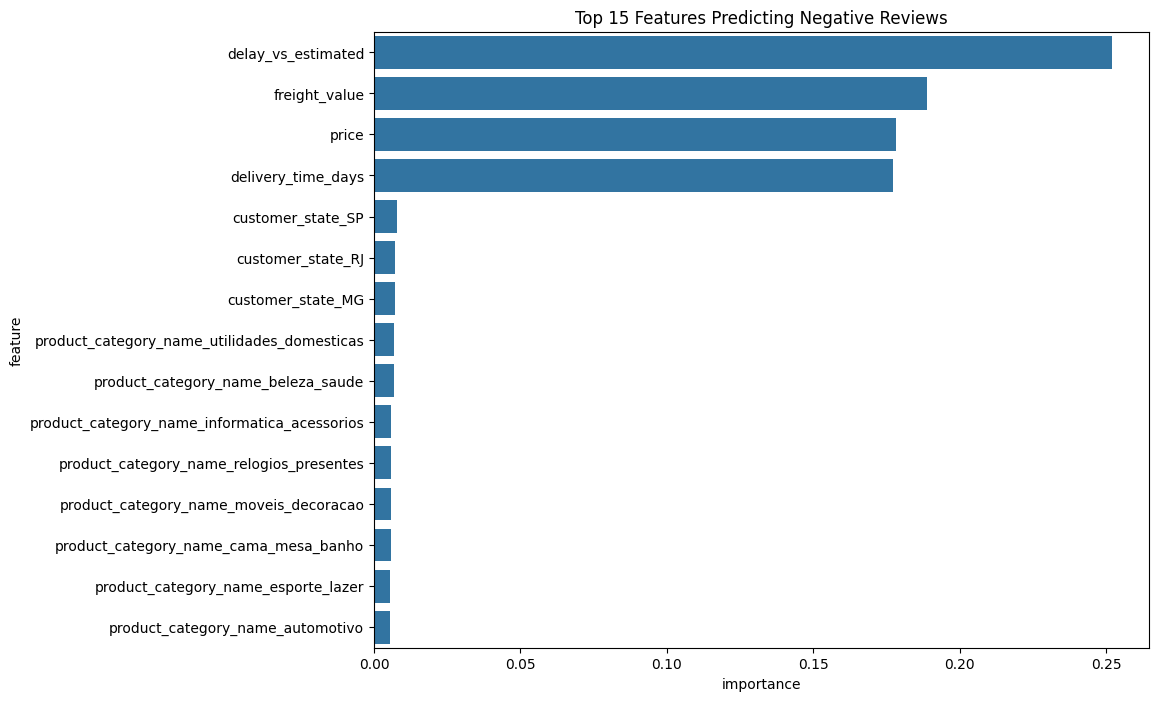

In [11]:
import numpy as np

# 1. استخراج أسماء المتغيرات (بعد الـ OneHotEncoding)
feature_names = numeric_features + \
                list(clf.named_steps['preprocessor']
                     .named_transformers_['cat']
                     .get_feature_names_out(categorical_features))

# 2. استخراج الأهمية
importances = clf.named_steps['model'].feature_importances_

# 3. تجميعهم مع بعض وترتيبهم
feature_importance_df = pd.DataFrame(
    {'feature': feature_names, 'importance': importances}
).sort_values('importance', ascending=False)

# 4. عرض أهم 10 متغيرات
print("\nTop 10 Most Important Features:")
print(feature_importance_df.head(10))

# 5. (اختياري بس مهم) اعمل رسم بياني ليهم
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 8))
sns.barplot(x='importance', y='feature', data=feature_importance_df.head(15))
plt.title('Top 15 Features Predicting Negative Reviews')
plt.show()